# Processing dataset and creation of Dataloaders

In [1]:
# Import standard libraries
import sys, os, shutil, time
from pathlib import Path
# For audio and MIDI processing
import pretty_midi
import IPython
# For numerical processing
import numpy as np
import torch
# For parallel processing
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
# For statistical analysis
from collections import Counter
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# For data splitting
from sklearn.model_selection import train_test_split

# Import this project modules
REPO_ROOT = Path('.').resolve().parent
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from src.data.dataset import PianoDataset, MidiPreprocessor
from src.utils.visualization import display_prettymidi
from src.utils.tools import piano_roll_to_pretty_midi

#### Initialization

In [2]:
midi_path = REPO_ROOT / 'data' / 'maestro-v3.0.0'
metadata_path = REPO_ROOT / 'data' / 'maestro-v3.0.0' / 'maestro-v3.0.0.csv'
processing_results_path = REPO_ROOT / 'data' / 'processing_results_details.csv'

# Solves problem of path with final dot
if os.name == 'nt':
    midi_path = Path(f"\\\\?\\{str(midi_path.resolve())}")

# Get list of all MIDI files
midi_files = list(midi_path.rglob('*.mid')) + list(midi_path.rglob('*.midi'))

selected_instruments = range(8)  # Piano and related instruments

## 1. Load Data
Load the dataset from the CSV file.

In [3]:
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found at {path}")
    return pd.read_csv(path)

try:
    df = load_data(metadata_path)
    print(f"Loaded dataset with {len(df)} entries.")
except Exception as e:
    print(f"Error loading data: {e}")

# Copy the original DataFrame and modify it
df_processed = df.copy()

# Drop columns
cols_to_drop = ['audio_filename']
df_processed = df_processed.drop(columns=cols_to_drop, errors='ignore')

# Add columns
df_processed['segments'] = 0
df_processed['bpms'] = [[] for _ in range(len(df_processed))]
df_processed['instruments'] = [[] for _ in range(len(df_processed))]
df_processed['errors'] = [[] for _ in range(len(df_processed))]

Loaded dataset with 1276 entries.


## Preprocessing

In [4]:
midi_path = REPO_ROOT / 'data' / 'maestro-v3.0.0'
# Solves problem of path with final dot
if os.name == 'nt':
    midi_path = Path(f"\\\\?\\{str(midi_path.resolve())}")
npz_path = REPO_ROOT / 'data' / 'processed_npz'
segments_details_path = REPO_ROOT / 'data' / 'segments_details.tsv'
processing_results_path = REPO_ROOT / 'data' / 'processing_report.txt'

# Get list of all MIDI files
midi_files = list(midi_path.rglob('*.mid')) + list(midi_path.rglob('*.midi'))

selected_instruments = range(8)  # Piano and related instruments

Questa cella si può anche skippare se il preprocessing è già stato fatto

In [5]:
# Clean the whole directory
shutil.rmtree(npz_path)
npz_path.mkdir(parents=True, exist_ok=True)
(npz_path / '.gitkeep').touch()

# Initialize Stats
valid_source_files = 0
total_segments = 0
error_counts = Counter()
detailed_errors = []

# Initialize Processor
processor = MidiPreprocessor(
    output_dir=npz_path,
    select_instruments=selected_instruments,
    note_start=24,
    note_end=84,
    min_notes=20,
    min_polyphony=1.0
)

# --- CORE LOGIC ---
with open(segments_details_path, 'w') as f_meta:
    # Write Header (Tab Separated)
    f_meta.write("filename\tinstrument\tfs\tbpm\toriginal_file\n")

    # Use multiprocessing Pool to speed up execution
    with Pool(processes=cpu_count()) as pool:

        # imap_unordered is efficient for streaming results as they finish
        iterator = pool.imap_unordered(processor, midi_files, chunksize=4)
        for result in tqdm(iterator, total=len(midi_files), desc="Processing & Saving", ncols=150):
            
            # Positive result analysis
            if isinstance(result, list) and len(result) > 0:
                valid_source_files += 1
                total_segments += len(result)
                # Write row to TSV immediately
                for seg in result:
                    f_meta.write(f"{seg['filename']}\t{seg['instrument']}\t{seg['fs']:.2f}\t{seg['bpm']:.2f}\t{seg['original_file']}\n")

            # Error storage
            elif isinstance(result, str):
                # String means a handled error or discard message
                if result.startswith("ERROR"):
                    error_counts["Exception"] += 1
                    detailed_errors.append(result)
                elif result.startswith("DISCARDED"):
                    if "NO PIANO" in result:
                        error_counts["No Piano"] += 1
                    elif "NO VALID SEGMENTS" in result:
                        error_counts["Segment Invalid"] += 1
                    else:
                        error_counts["Other Discard"] += 1
# --- Reporting ---
# Save processing details to text file
with open(processing_results_path, 'w') as f:
    f.write("="*40 + "\n PREPROCESSING REPORT \n" + "="*40 + "\n")
    f.write(f"Total files: {len(midi_files)}\n")
    f.write(f"Processed successfully: {valid_source_files}\n")
    f.write(f"Total segments generated: {total_segments}\n\n")
    f.write("DISCARDS & ERRORS:\n")
    for k, v in error_counts.items():
        f.write(f"  {k}: {v}\n")
    f.write("\nDETAILED ERRORS:\n")
    for err in detailed_errors:
        f.write(f"{err}\n")
print("\nProcessing complete.")
print(f"Segments: {total_segments}. Errors: {sum(error_counts.values())}")
print(f"Intermediate .npz files saved to: {npz_path}")

Processing & Saving: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1276/1276 [07:45<00:00,  2.74it/s]



Processing complete.
Segments: 44117. Errors: 0
Intermediate .npz files saved to: C:\Users\Andrea\Documents\Università\Magistrale\Deeplearning\NNDL-project\data\processed_npz


# Analisi dei segmenti ottenuti

 PREPROCESSING REPORT
Total files: 1276
Processed successfully: 1276
Total segments generated: 44117

DISCARDS & ERRORS:

DETAILED ERRORS:


,instrument,fs,bpm,original_file
filename,,,,
2004_MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav_0.npz,0,8.0,120.0,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...
2004_MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav_1.npz,0,8.0,120.0,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...
2004_MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav_2.npz,0,8.0,120.0,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...
2004_MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav_3.npz,0,8.0,120.0,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...
2004_MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav_4.npz,0,8.0,120.0,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...


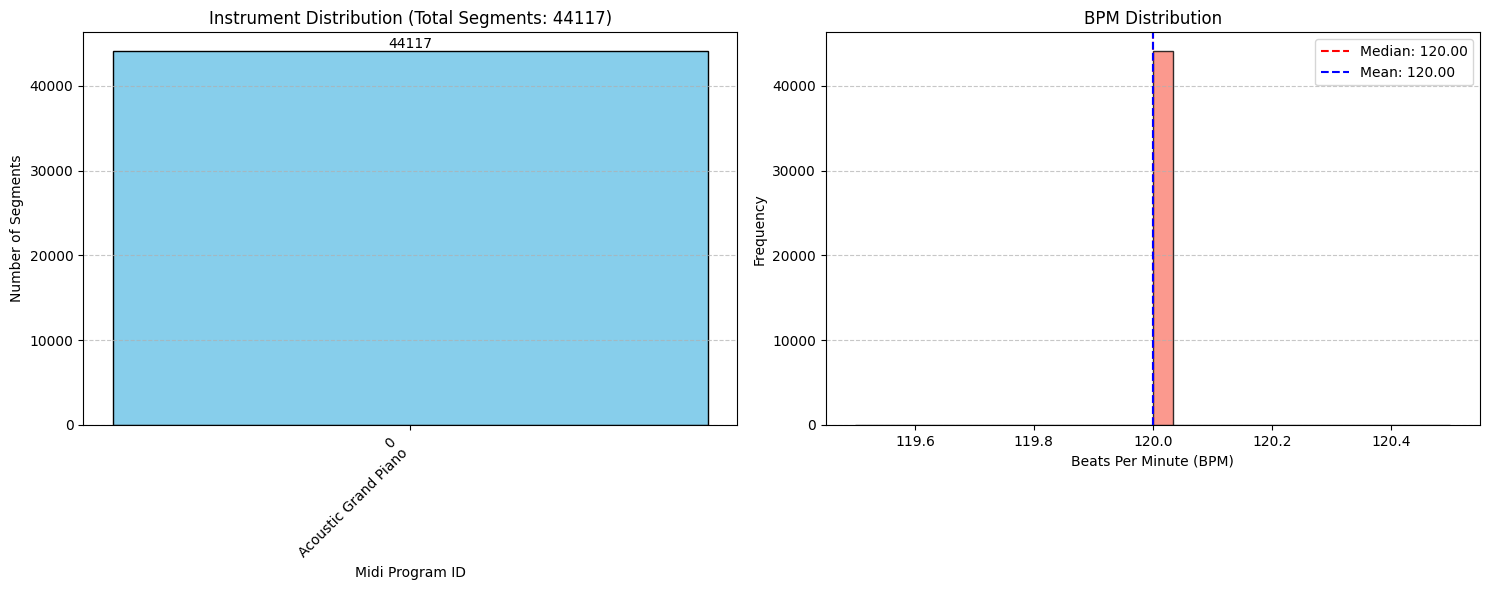

In [6]:
try:
    with open(processing_results_path, 'r') as f:
        for _ in range(20):
            line = f.readline()
            if not line:
                break
            print(line.rstrip())

except FileNotFoundError:
    print(f"File not found: {processing_results_path}")
    
try:
    df_analysis = pd.read_csv(segments_details_path, sep='\t')
    df_analysis = df_analysis.set_index('filename')

    display(df_analysis.head(5))

    # Extraction data from columns
    instruments = df_analysis['instrument'].values
    bpms = df_analysis['bpm'].values

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # --- Histogram Instruments ---
    instr_counts = Counter(instruments)
    
    # Identify present instruments
    present_instrs = sorted(list(instr_counts.keys()))
    counts = [instr_counts[i] for i in present_instrs]
    # Obtain readable names
    instr_labels = [pretty_midi.program_to_instrument_name(int(i)) for i in present_instrs]
    
    # Display Bars
    bars = ax1.bar([str(i) for i in present_instrs], counts, color='skyblue', edgecolor='black')
    ax1.set_title(f'Instrument Distribution (Total Segments: {len(df_analysis)})')
    ax1.set_xlabel('Midi Program ID')
    ax1.set_ylabel('Number of Segments')
    # Customize x-ticks with instrument names
    ax1.set_xticks(range(len(present_instrs)))
    ax1.set_xticklabels([f"{i}\n{l}" for i, l in zip(present_instrs, instr_labels)], rotation=45, ha='right')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')

    # --- Histogram BPM ---
    ax2.hist(bpms, bins=30, color='salmon', edgecolor='black', alpha=0.8)
    ax2.set_title('BPM Distribution')
    ax2.set_xlabel('Beats Per Minute (BPM)')
    ax2.set_ylabel('Frequency')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Statistics
    median_bpm = np.median(bpms)
    mean_bpm = np.mean(bpms)
    
    ax2.axvline(median_bpm, color='red', linestyle='dashed', linewidth=1.5, label=f'Median: {median_bpm:.2f}')
    ax2.axvline(mean_bpm, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_bpm:.2f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("ERROR: File not found. Run the saving step first.")

## Load the datasets

In [7]:
def benchmark_loader(loader, num_epochs=1):
    print(f"Start benchmark on {len(loader)} batches for {num_epochs} epochs...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Simulating transfer to: {device}")

    start_time = time.time()
    total_batches = 0
    
    for epoch in range(num_epochs):
        # tqdm gives us a progress bar with real-time speed estimation
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for batch_idx, (prev_bar, curr_bar) in enumerate(pbar):
            # We simulate ONLY the transfer to GPU memory (which has a cost)
            # We do not perform forward/backward pass
            prev_bar = prev_bar.to(device, non_blocking=True)
            curr_bar = curr_bar.to(device, non_blocking=True)
            
            total_batches += 1
            
    end_time = time.time()
    total_time = end_time - start_time
    
    print("\n=== Benchmark Results ===")
    print(f"Total Time: {total_time:.2f} seconds")
    print(f"Batches Processed: {total_batches}")
    print(f"Mean Velocity: {total_batches / total_time:.2f} batch/second")
    print(f"Throughput: {(total_batches * loader.batch_size) / total_time:.2f} samples/second")
    print("===========================")

### New dataset loader using memory mapping

In questo caso ogni sample è una singola coppia (prev_bar, curr_bar) e quindi ogni estrazione è i.i.d.

In [8]:
try:
    with open(processing_results_path, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            if line.startswith("Total segments generated:"):
                total_segments = int(line.strip().split(":")[-1])
                break
except FileNotFoundError:
    print(f"File not found: {processing_results_path}")

all_indices = np.arange(total_segments)

# Split indices (80% Train, 10% Val, 10% Test)
train_indices, temp_indices = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, shuffle=True)

print(f"Train Segments: {len(train_indices)}")
print(f"Val Segments:   {len(val_indices)}")
print(f"Test Segments:  {len(test_indices)}")

# Instantiate the Datasets
train_dataset = PianoDataset(npz_path, split_indices=train_indices)
val_dataset   = PianoDataset(npz_path, split_indices=val_indices)
test_dataset  = PianoDataset(npz_path, split_indices=test_indices)

# Create the DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=72, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=72, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=72, shuffle=False, num_workers=0)

# Benchmark the DataLoader
benchmark_loader(train_loader, num_epochs=1)


Train Segments: 35293
Val Segments:   4412
Test Segments:  4412


Loading PianoDataset: 100%|██████████| 4412/4412 [01:06<00:00, 66.35it/s]


Start benchmark on 3922 batches for 1 epochs...
Simulating transfer to: cuda


Epoch 1/1: 100%|██████████| 3922/3922 [00:10<00:00, 388.91batch/s]


=== Benchmark Results ===
Total Time: 10.09 seconds
Batches Processed: 3922
Mean Velocity: 388.85 batch/second
Throughput: 27997.10 samples/second


Previous bars shape: torch.Size([72, 1, 128, 16])
Current bars shape: torch.Size([72, 1, 128, 16])


C:\Users\Andrea\Documents\Università\Magistrale\Deeplearning\NNDL-project\src\utils\visualization.py:29: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(


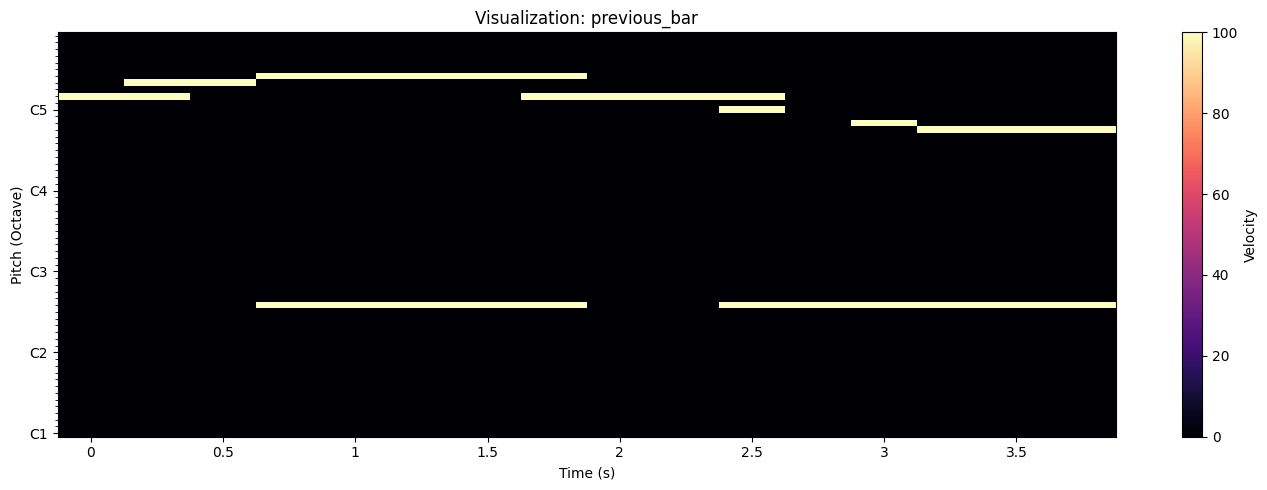

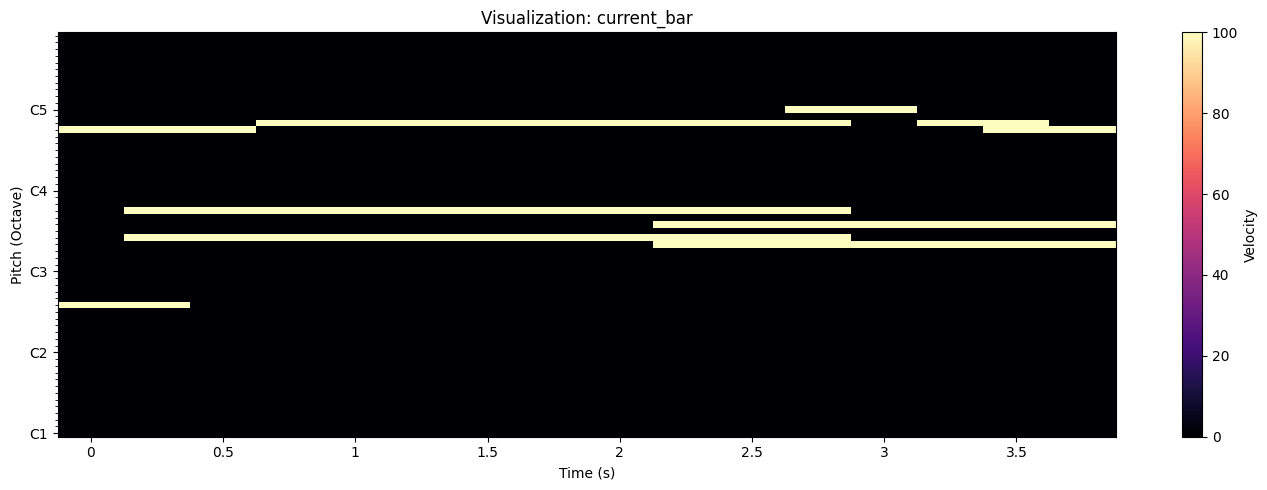

Concatenated bars shape: torch.Size([1, 128, 32])


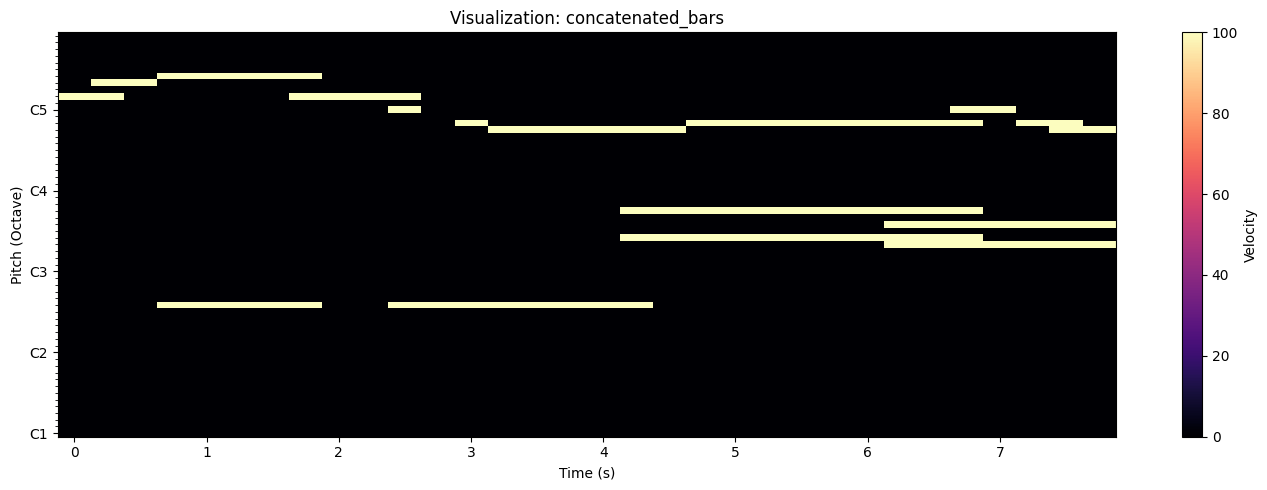

In [9]:
# Visualize a sample from the DataLoader
prev_bar, current_bar = next(iter(train_loader))
print("Previous bars shape:", prev_bar.shape)
print("Current bars shape:", current_bar.shape)

prev_pm = piano_roll_to_pretty_midi(prev_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    prev_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: previous_bar"
)
current_pm = piano_roll_to_pretty_midi(current_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    current_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: current_bar"
)

# Concatenate previous and current bars
concatenated_bars = torch.cat((prev_bar[1], current_bar[1]), dim=2)  # Concatenate along time axis
print("Concatenated bars shape:", concatenated_bars.shape)

concatenated_pm = piano_roll_to_pretty_midi(concatenated_bars.squeeze().numpy()*100, fs=4)
display_prettymidi(
    concatenated_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: concatenated_bars"
)

audio = IPython.display.Audio(concatenated_pm.fluidsynth(fs=16000), rate=16000)
IPython.display.display(audio)